# Notebook for Data Processing for DL
1. (Done) Load Satellite Image Tile 
2. (Done) Load Corresponding Vector GeoJSON (Note: Import POLYGON data, not LINES or POINTS)
3. (Done) In Loaded Vector, rename 'DN' to 'class_id' (Call convert_feature_to_class_id)
4. (Done) To the loaded GeoJSON, remove the 'class_id' where the number of examples of the class is 0 and decrease the class_ids above it (classes where examples exist) so that we do not have gaps in the middle (Test to see if this is required)
5. (Done) Rasterize the vector
6. (Done) Create labels (Semantic mask) for the satellite image
7. (Done) In the satellite image, zero out any pixels where the semantic mask is also 0
8. (Done) Add A Channel of Latitude and Longitude to the image
9. (Done) Use a sliding window to create blocks of data and corresponding label, then store the data locally

In [1]:
from rastervision.core.data import (
    RasterioSource,
    GeoJSONVectorSource,
    RasterioCRSTransformer,
    BufferTransformer,
    RasterizedSource,
    ClassInferenceTransformer,
    ClassConfig,
    SemanticSegmentationLabelSource,
    Scene)

from rastervision.pytorch_learner import (
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

import tifffile
import json
import numpy as np
from src.plot_geoms import plot_geoms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import rasterio
from osgeo import gdal
import torch
import os
import os.path
import json
import cv2

2023-04-15 13:00:19:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpcty939iu


In [2]:
# (Move this to utils file)
#Function call to convert DN to class_id
def convert_feature_to_class_id(feature_name:str):
    #This modifies the underlying GeoJSON in vector_source
    try:
        for feature in vector_data['features']:
            feature['properties']['class_id'] = feature['properties'].pop(feature_name)
    except:
        print("The feature does not exist in the dictionary")
        
        
#Allows to check examples of a class existing
def return_class_example(class_id:int,vector_data:dict):
    data = []
    for i in range(len(vector_data['features'])):
        if vector_data['features'][i]['properties']['class_id'] == class_id:
            data.append(vector_data['features'][i])
    return data
    

      
#Function to remove the null classes
def remove_unwanted_classes(geojson:dict, inplace = False):
    if inplace == False:
        from copy import deepcopy
        mod_geojson = deepcopy(geojson)
    else:
        mod_geojson = geojson
    num_points = {k:0 for k in range(12)}
    num_points_after = {k:0 for k in range(12)}
    classes_to_show = []
    
    for feature in mod_geojson['features']:
        # Get the current class_id
        # Getting the class memberships
        class_id = feature['properties']['class_id']
        num_points[class_id]+=1

    

    print("Class Membership(Before)")
    for k,v in num_points.items():
        print(k, v)
        if v!=0 or k==0:
            classes_to_show.append(k)
    
    #Get the classes with 0 points in them
    remove_classes = [3,6,10]
    remove_classes.sort()
    remove_classes = list(map(lambda x: x - remove_classes.index(x),remove_classes))
    
    #Iterate through remove_classes and shift class_id (only for 3, 6 and 10)
    for remove_id in remove_classes:
        for feature in mod_geojson['features']:
            class_id = feature['properties']['class_id']
            if class_id > remove_id:
                feature['properties']['class_id'] = class_id - 1
                
    for feature in mod_geojson['features']:
    # Get the current class_id
    # Getting the class memberships
        class_id = feature['properties']['class_id']
        num_points_after[class_id]+=1
    
    
    print("\n\nClass Membership(After)")
    for k,v in num_points_after.items():
        print(k, v)
    
    if inplace == False:
        return mod_geojson
    

In [3]:
#Setting environment variables for Rasterio
import os
from subprocess import check_output

os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
#GPU Check
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [5]:
#All Drive Locations
BASE_IMAGE_FOLDER = '../data/2021/Raw Satellite Images'
VECTOR_FOLDER = '../data/2021/Raw Vectors'
CLIPPED_IMAGE_FOLDER = '../data/2021/Clipped Satellite Rasters'

In [6]:
#View all images in image folder
#If you put images in the BASE_IMAGE_FOLDER, the paths of the files
#will be put in a list which you can then easily index instead of putting
#the entire path
all_images = [os.path.join(BASE_IMAGE_FOLDER,file) for file in os.listdir(BASE_IMAGE_FOLDER) if file.endswith('.tif')]
all_images.sort()
all_images

['../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000000000-0000000000.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000000000-0000016384.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000000000-0000032768.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000000000-0000049152.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000016384-0000000000.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000016384-0000016384.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000016384-0000032768.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000016384-0000049152.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000032768-0000000000.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000032768-0000016384.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000032768-0000032768.tif',
 '../data/2021/Raw Satellite Images/Sentinel-2_2021_UAE-0000032768-000004915

In [9]:
#View all vector files in folder
all_vector_data = [os.path.join(VECTOR_FOLDER,file) for file in os.listdir(VECTOR_FOLDER) if file.endswith('.geojson')]
all_vector_data

['../data/2021/Raw Vectors/Vectorized_16384_32768.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000016384-0000049152.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000000000-0000000000.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000000000-0000016384.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000000000-0000032768.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000000000-0000049152.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000016384-0000000000.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000016384-0000016384.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000032768-0000000000.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000032768-0000016384.geojson',
 '../data/2021/Raw Vectors/Clipped_2021_UAE-0000032768-0000032768.geojson']

# Loading The Initial Satellite Image and Vector Data

In [8]:
#Loading a given Satellite Image
raster_tile_1 = RasterioSource(all_images[-2],
                               channel_order=[2,1,0],
                               allow_streaming = False)
raster_tile_1_arr = raster_tile_1.get_image_array()

Warning 1: PROJ: proj_create_from_database: /home/ac18/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [10]:
#Loading the corresponding Label (Vector Polygon file)
crs_transformer = RasterioCRSTransformer.from_uri(all_images[-2])

vector_source = GeoJSONVectorSource(all_vector_data[-1],
                                    crs_transformer,
                                    ignore_crs_field=True,
                                    vector_transformers=[ClassInferenceTransformer(default_class_id=0)])

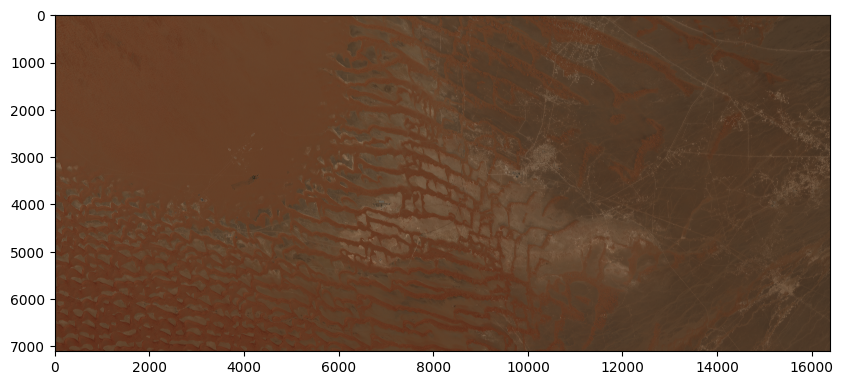

In [11]:
#Visualizing the Satellite Image
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raster_tile_1_arr)

In [12]:
#To get an idea on the shape of the Satellite Image
raster_tile_1.shape

(7105, 16384, 3)

In [13]:
#Loads the label (vector polygon) into memory and performs some transformations
# This is the longest step in the process
vector_data = vector_source.get_geojson()

Transforming to pixel coords:  46%|####6     | 11370/24528 [00:05<00:05, 2273.96it/s]

Simplifying polygons:  65%|######5   | 16053/24528 [00:06<00:03, 2340.72it/s]

In [14]:
# Viewing vector_data in JSON style
vector_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((169.0, 0.0),
      (169.0, 1.0),
      (170.0, 1.0),
      (170.0, 2.0),
      (171.0, 2.0),
      (171.0, 1.0),
      (172.0, 1.0),
      (172.0, 0.0),
      (169.0, 0.0)),)},
   'properties': {'fid': 1, 'DN': 8, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((270.0, 0.0),
      (270.0, 1.0),
      (272.0, 1.0),
      (272.0, 0.0),
      (270.0, 0.0)),)},
   'properties': {'fid': 2, 'DN': 11, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((433.0, 0.0),
      (433.0, 2.0),
      (436.0, 2.0),
      (436.0, 1.0),
      (438.0, 1.0),
      (438.0, 0.0),
      (433.0, 0.0)),)},
   'properties': {'fid': 3, 'DN': 8, 'class_id': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((1091.0, 0.0),
      (1091.0, 1.0),
      (1092.0, 1.0),
      (1092.

In [15]:
#Renames 'DN' into 'class_id'
convert_feature_to_class_id('DN')

In [16]:
#Removes the empty classes and gives info on class membership
show_classes = remove_unwanted_classes(vector_data,inplace = True)

Class Membership(Before)
0 0
1 2
2 0
3 0
4 0
5 2
6 0
7 46
8 10580
9 0
10 0
11 13898


Class Membership(After)
0 0
1 2
2 0
3 0
4 2
5 46
6 10580
7 0
8 13898
9 0
10 0
11 0


# Rasterizing Vector Data

In [17]:
# Create a raster of the vector data
rasterized_source = RasterizedSource(
    vector_source,
    background_class_id=0,
    extent=raster_tile_1.extent) # RasterSource's extent = Extent of Satellite Image

In [18]:
# Check shape of label (The first two should match the first two of the satellite image)
rasterized_source.shape

(7105, 16384, 1)

In [19]:
# Getting the array of the label
vector_raster = rasterized_source.get_image_array()

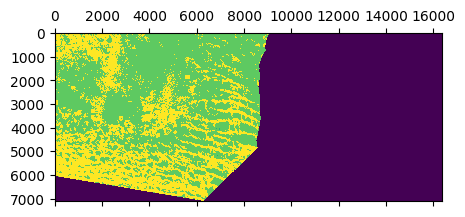

In [20]:
#Visualize the label raster
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(vector_raster)
plt.show()

# Reading Labels of the data

In [21]:
#Creating Class Config
class_config = ClassConfig(names = ["null",
                                   "Water",
                                   "Trees",
                                   "Floded Vegetation",
                                   "Crops",
                                   "Built Area",
                                   "Bare Ground",
                                   "Snow/Ice",
                                   "Rangeland"])
class_config

ClassConfig(names=['null', 'Water', 'Trees', 'Floded Vegetation', 'Crops', 'Built Area', 'Bare Ground', 'Snow/Ice', 'Rangeland'], colors=[(117, 221, 44), (202, 199, 48), (36, 113, 220), (160, 188, 122), (157, 16, 156), (173, 67, 209), (250, 55, 139), (102, 71, 20), (82, 81, 200)], null_class='null')

In [22]:
#Setting color for null to black
class_config.colors[0] = 'black'
class_config.colors[1] = (43,77,15)
class_config.colors[2] = (24, 140, 200)
class_config.colors[3] = (47, 201, 19)
class_config.colors[4] = (121, 131, 141)
class_config.colors[5] = (63, 31, 52)
class_config.colors[6] = (155, 160, 212)
class_config.colors[7] = (226, 24, 202)
class_config.colors[8] = (4, 73, 35)

In [23]:
class_config

ClassConfig(names=['null', 'Water', 'Trees', 'Floded Vegetation', 'Crops', 'Built Area', 'Bare Ground', 'Snow/Ice', 'Rangeland'], colors=['black', (43, 77, 15), (24, 140, 200), (47, 201, 19), (121, 131, 141), (63, 31, 52), (155, 160, 212), (226, 24, 202), (4, 73, 35)], null_class='null')

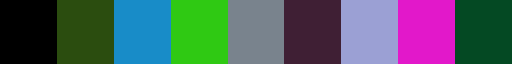

In [24]:
#Color card representing the data
from matplotlib.colors import ListedColormap
cmap = ListedColormap(class_config.color_triples)
cmap

# Creating Semantic Segmantion Labels

In [25]:
label_rasters = SemanticSegmentationLabelSource(
                rasterized_source, class_config = class_config)
label_raster_arr = label_rasters.get_label_arr()

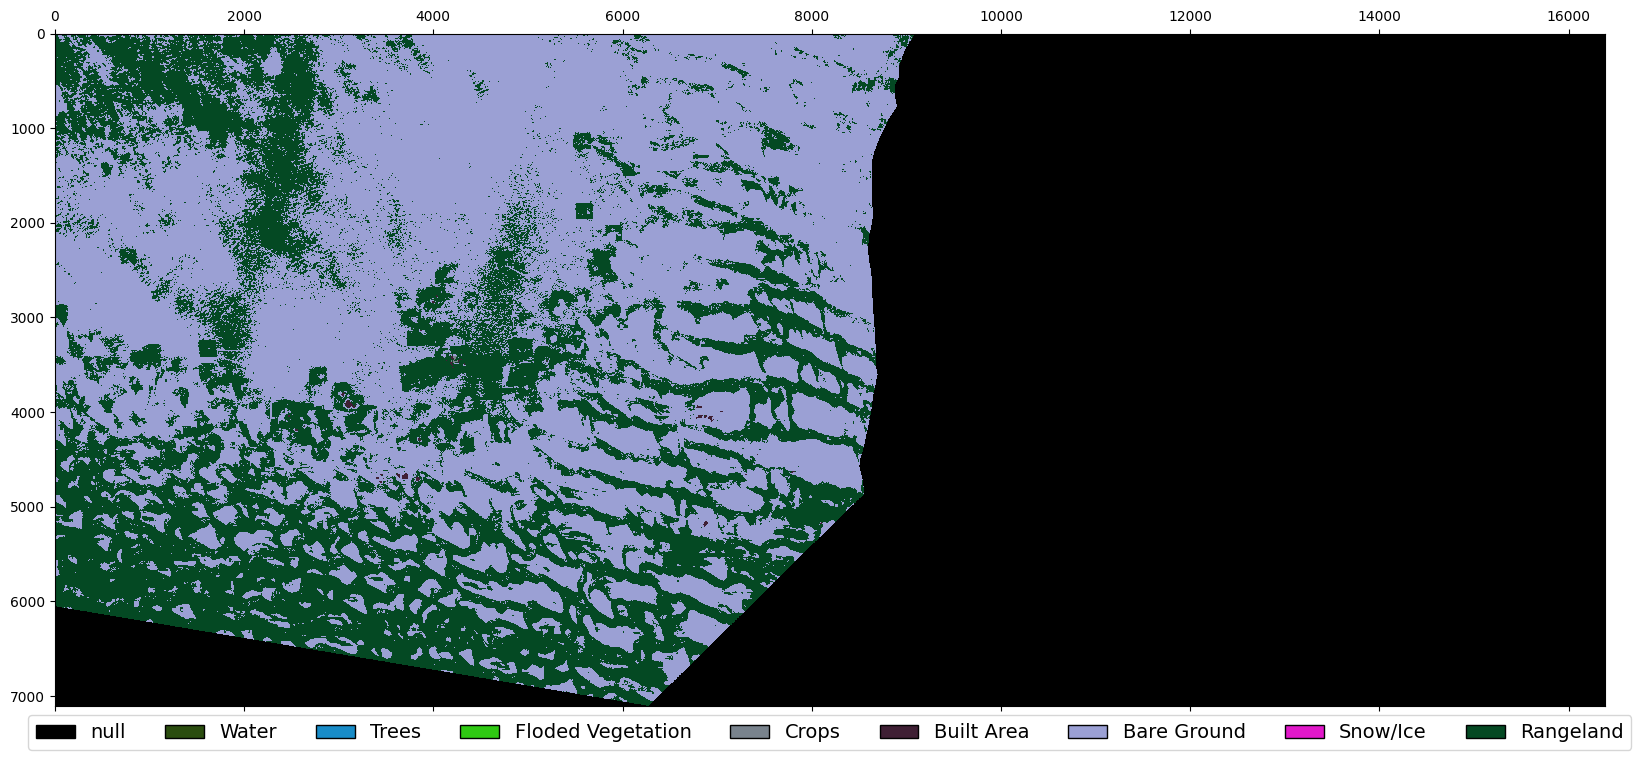

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches

fig,ax = plt.subplots(figsize=(20,20))
cmap = ListedColormap(class_config.color_triples)
ax.matshow(label_raster_arr, cmap = cmap)

legend_items = [
    patches.Patch(facecolor=cmap(i),edgecolor='black',label=cname)
    for i, cname in enumerate(class_config.names)]
ax.legend(
    handles=legend_items,
    ncol=len(class_config),
    loc='upper center',
    fontsize=14,
    bbox_to_anchor=(0.5,0))
plt.show()

# Clip the Original Satellite Image and add Lat/Long information

In [27]:
#Eliminates Null data info from satellite images 
#IMPORTANT
def clip_image_to_label(img:np.array, label:np.array):
    assert img.shape[:-1] == label.shape
    for i in tqdm(range(label.shape[0])):
        for j in range(label.shape[1]):
            if(label[i,j] == 0):
                img[i,j,:] = 0
    return img

In [28]:
mod_raster_tile_1 = clip_image_to_label(raster_tile_1_arr,label_raster_arr)

100%|███████████████████████████████████████| 7105/7105 [02:43<00:00, 43.57it/s]


In [29]:
#Write Modded file to memory
#Modify the name of the file according to the convention : YEAR_TILEVAL1_TILEVAL2
import tifffile
tifffile.imsave(os.path.join(CLIPPED_IMAGE_FOLDER,'2021_32768_32768.tif'),
                mod_raster_tile_1,
                planarconfig='contig')


In [30]:
#View all images in Clipped Image Folder
clipped_images = [os.path.join(CLIPPED_IMAGE_FOLDER,file) for file in os.listdir(CLIPPED_IMAGE_FOLDER) if file.endswith('.tif')]
clipped_images.sort()
clipped_images

['../data/2021/Clipped Satellite Rasters/2021_00000_00000.tif',
 '../data/2021/Clipped Satellite Rasters/2021_00000_16384.tif',
 '../data/2021/Clipped Satellite Rasters/2021_00000_32768.tif',
 '../data/2021/Clipped Satellite Rasters/2021_00000_49152.tif',
 '../data/2021/Clipped Satellite Rasters/2021_16384_00000.tif',
 '../data/2021/Clipped Satellite Rasters/2021_16384_16384.tif',
 '../data/2021/Clipped Satellite Rasters/2021_16384_32768.tif',
 '../data/2021/Clipped Satellite Rasters/2021_16384_49152.tif',
 '../data/2021/Clipped Satellite Rasters/2021_32768_00000.tif',
 '../data/2021/Clipped Satellite Rasters/2021_32768_16384.tif',
 '../data/2021/Clipped Satellite Rasters/2021_32768_32768.tif']

In [31]:
#Load Modified Raster
raster_modified = RasterioSource(clipped_images[-1],
                                allow_streaming=False)

2023-04-15 13:08:08:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (1, 16384) is too non-square. This can slow down reading. Consider re-tiling using GDAL.


In [32]:
raster_modified.shape

(7105, 16384, 3)

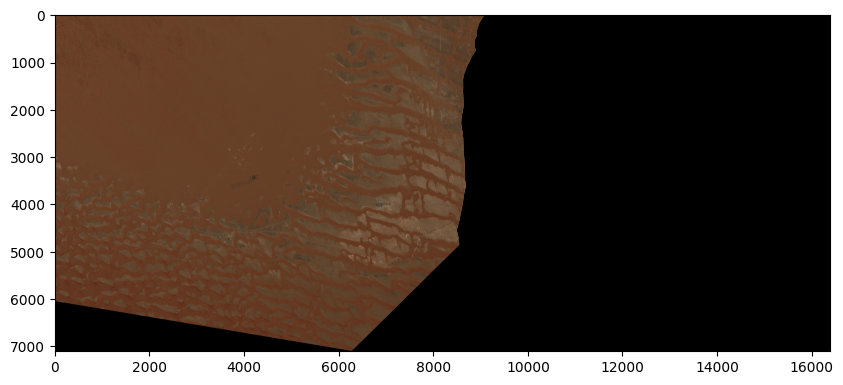

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raster_modified.get_image_array())

# Sampling the data

In [34]:
#create a Scence object
scence = Scene(id = "1",
              raster_source=raster_modified,
              label_source=label_rasters)


In [35]:
ds = SemanticSegmentationSlidingWindowGeoDataset(
                scene = scence,
                size = 1024,
                stride = 1024,
                to_pytorch = True)

In [44]:
X,y = ds[96]
X.shape, y.shape

(torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))

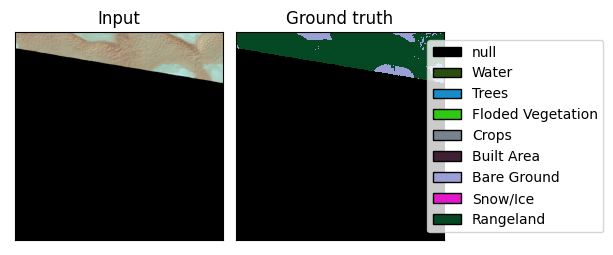

In [42]:
viz = SemanticSegmentationVisualizer(
       class_names=class_config.names, class_colors=class_config.colors)
viz.plot_batch(X.unsqueeze(0),y.unsqueeze(0),show=True)

# Save processed data to disk

In [53]:
from PIL import Image
from torchvision.utils import save_image 
BASE_FILENAME = '2021_32768_32768.png'
IMG_FILEPATH = '/home/ac18/Senior Design Project/LULC_UAE_DL/data/2021/Processed Data/images'
MASKS_FILEPATH = '/home/ac18/Senior Design Project/LULC_UAE_DL/data/2021/Processed Data/masks'

count = 1
for i,(X,y) in enumerate(tqdm(ds)):
    if i == 96:
        continue
    if(torch.count_nonzero(y) != 0):
        save_image(X,
                  os.path.join(IMG_FILEPATH,str(count)+'_'+BASE_FILENAME))
        im = Image.fromarray(y.numpy())
        im.save(os.path.join(MASKS_FILEPATH,str(count)+'_'+BASE_FILENAME))
        count+=1

                   
        



 87%|████████████████████████████████████▍     | 97/112 [03:42<00:34,  2.29s/it]


TypeError: Cannot handle this data type: (1, 1), <i8

In [56]:
y.numpy().dtype

dtype('int64')

In [52]:
print(i)

96
